## BLU06 - Learning Notebook - Part 3 of 3 - Time Series Cross Validation and Uncertainty

In [1]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 8)

import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

import utils

In [2]:
store = utils.get_store_data()
store['date'] = pd.to_datetime(store['date'], format='%Y-%m-%d')
store = store.set_index('date')
store = store.sort_index()

In [3]:
store_resampled = store.resample('D').mean()
store_cleaned = store_resampled.fillna(0)
store_cleaned = store_cleaned.customers

In [4]:
test_split_date = '2017-6'
store_train = store_cleaned.loc[store_cleaned.index < test_split_date]
store_test = store_cleaned.loc[store_cleaned.index >= test_split_date]

## Functions

In [5]:
def build_target(series_, number_of_periods_ahead):
    """ 
    takes a series, turned it into a dataframe, and adds a new column called target
    This column is the input series, lagged number_of_periods_ahead into the future
    """
    
    # make a copy 
    series_ = series_.copy()
    series_.name = 'customers'
    
    # make a dataframe from the series
    df_ = pd.DataFrame(series_)
    
    # the target column will be the input series, lagged into the future
    df_['target'] = series_.shift(-number_of_periods_ahead)
    return df_

In [6]:
def separate_last_day(df_):
    
    """
    takes a dataset which has the target and features built 
    and separates it into the last day
    """
    # take the last period 
    last_period = df_.iloc[-1]
    
    # the last period is now a series, so it's name will be the timestamp
    training_data = df_.loc[df_.index < last_period.name]

    return last_period, training_data

In [7]:
def build_some_features(df_, num_periods_lagged=1, num_periods_diffed=0, weekday=False, month=False, rolling=[], holidays=False): 
    """
    Builds some features by calculating differences between periods  
    """
    # make a copy 
    df_ = df_.copy()
        
    # for a few values, get the lags  
    for i in range(1, num_periods_lagged+1):
        # make a new feature, with the lags in the observed values column
        df_['lagged_%s' % str(i)] = df_['customers'].shift(i)
        
    # for a few values, get the diffs  
    for i in range(1, num_periods_diffed+1):
        # make a new feature, with the lags in the observed values column
        df_['diff_%s' % str(i)] = df_['customers'].diff(i)
    
    for stat in rolling:
        df_['rolling_%s'%str(stat)] = df_['customers'].rolling('7D').aggregate(stat)
        
    if weekday == True:
        df_['sin_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        df_['cos_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        
    if month == True:
        df_['sin_month'] = np.sin(2*np.pi*df_.index.month/12)
        df_['cos_month'] = np.sin(2*np.pi*df_.index.month/12)
        
    if holidays == True:
        holidays = df_[((df_.index.month==12) & (df_.index.day==25))
              |((df_.index.month==1) & (df_.index.day==1))].customers
        df_['holidays'] = holidays + 1
        df_['holidays'] = df_['holidays'].fillna(0)
    
    return df_

In [8]:
def separate_train_and_test_set(last_period_, training_data_, target='target'): 
    
    """ 
    separates training and test set (clue was in the name, really... )
    Ok, we were lazy and left the target hardcoded as 'target'. Shame on us. 
    """
    
    # anything that isn't a target is a feature 
    features = [feature for feature in training_data_.columns if feature != target]
    
    # adding a sneaky little dropna to avoid the missing data problem above 
    X_train = training_data_.dropna()[features]
    y_train = training_data_.dropna()[target]
    
    X_last_period = last_period_[features]
    
    return X_train, y_train, X_last_period

In [9]:
def prepare_for_prediction(series_, number_of_periods_ahead, num_periods_lagged, num_periods_diffed, weekday, month, rolling, holidays):
    
    """ 
    Wrapper to go from the original series to X_train, y_train, X_last_period 
    
    """
    
    # build the target 
    data_with_target = build_target(series_, 
                                    number_of_periods_ahead)
    
    # build the features 
    data_with_target_and_features = build_some_features(data_with_target, 
                                                        num_periods_lagged=num_periods_lagged,
                                                       num_periods_diffed=num_periods_diffed,
                                                       weekday=weekday,
                                                       month=month,
                                                       rolling=rolling,
                                                       holidays=holidays)
    # separate train and test data 
    last_period, training_data = separate_last_day(data_with_target_and_features)

    # separate X_train, y_train, and X_test 
    X_train, y_train, X_last_period = separate_train_and_test_set(last_period, 
                                                           training_data, 
                                                           target='target')
    
    # return ALL OF THE THINGS! (well, actually just the ones we need)
    return X_train, y_train, X_last_period 

In [10]:
def predict_period_n(series_, model, number_of_periods_ahead, num_periods_lagged, num_periods_diffed, weekday, month, rolling, holidays): 
    
        X_train, y_train, X_last_period = prepare_for_prediction(series_, 
                                                             number_of_periods_ahead, 
                                                             num_periods_lagged,
                                                             num_periods_diffed,
                                                             weekday,
                                                             month,
                                                             rolling,
                                                             holidays)
        
        model.fit(X_train, y_train)
        return model.predict(X_last_period.values.reshape(1, -1))

In [11]:
def predict_n_periods(series_, n_periods, model, num_periods_lagged, num_periods_diffed=0, weekday=False, month=False,rolling=[], holidays=False): 
    predictions = []

    for period_ahead in range(1, n_periods+1):
        pred = predict_period_n(series_=series_, 
                                model=model, 
                                number_of_periods_ahead=period_ahead, 
                                num_periods_lagged=num_periods_lagged,
                                num_periods_diffed=num_periods_diffed,
                                weekday=weekday,
                                month=month,
                                rolling=rolling,
                                holidays=holidays)
        
        predictions.append(pred[0])
        
    return predictions 

### Are there other ways of performing train-test split for time series? 

Unlike the datasets we used in the bootcamp and first hackathon where we wouldn't have any issues if we performed random train-test splits, in time series we must respect the order between train and test. Simply put, **all timestamps that appear in the train set must be smaller than the ones in test set**. A simple way to perform the train-test split in time series is to choose an arbitrary date like we did and split the time series into train and test. But, if we do this, we aren't able to check how well our model generalizes to different parts of the time series. An alternative train-test split method is the one implemented in sklearn, [TimeSeriesSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). Before using it, let's extract the time series for store 1

# Expanding Window

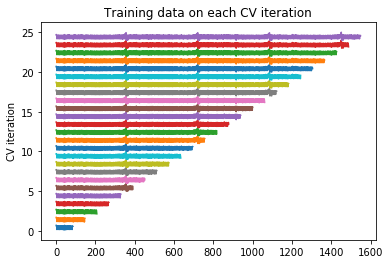

In [12]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=25)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(store_train/store_train.max())):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + store_train[tr]/store_train.max())

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

In [13]:
X = store_train

# Iterate through CV splits
n_splits = 25
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
#coefficients = np.zeros([n_splits, X.shape[1]])
idx_lst = []
values_lst = []
#switch = 0
for ii, (tr, tt) in tqdm(enumerate(cv.split(X))):
    # Fit the model on training data and collect the coefficients
    train = X[tr]
    test = X[tt]
    idx_lst.append(X.index[tt][0])
    error_lst = []
    predictions = predict_n_periods(series_=train, 
                    n_periods=len(test), 
                    model=GradientBoostingRegressor(), 
                    num_periods_lagged=2,
                    num_periods_diffed=0,
                    weekday=True,
                    month=False)
    values_lst.append(mean_absolute_error(test,predictions))

KeyboardInterrupt: 

In [ ]:
pd.Series(values_lst, index=idx_lst).plot()

# Sliding Window 

In [ ]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=25, max_train_size=365)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(store_train/store_train.max())):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + store_train[tr]/store_train.max())

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

In [ ]:
X = store_train

# Iterate through CV splits
n_splits = 25
cv = TimeSeriesSplit(n_splits=n_splits, max_train_size=365)

# Create empty array to collect coefficients
#coefficients = np.zeros([n_splits, X.shape[1]])
idx_lst = []
values_lst_block = []
#switch = 0
for ii, (tr, tt) in tqdm(enumerate(cv.split(X))):
    # Fit the model on training data and collect the coefficients
    train = X[tr]
    test = X[tt]
    idx_lst.append(X.index[tt][0])
    error_lst = []
    predictions = predict_n_periods(series_=train, 
                    n_periods=len(test), 
                    model=GradientBoostingRegressor(), 
                    num_periods_lagged=2,
                    num_periods_diffed=0,
                    weekday=True,
                    month=False)
    values_lst_block.append(mean_absolute_error(test,predictions))

In [ ]:
pd.Series(values_lst, index=idx_lst).plot()
pd.Series(values_lst_block, index=idx_lst).plot()

# Measuring Uncertainty

In [ ]:
predictions = predict_n_periods(series_=store_train, 
                  n_periods=len(store_test), 
                  model=GradientBoostingRegressor(), 
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  weekday=True,
                  month=False,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True
                  )

In [ ]:
predictions_max = predict_n_periods(series_=store_train, 
                  n_periods=len(store_test), 
                  model=GradientBoostingRegressor(loss='quantile',alpha=0.95), 
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  weekday=True,
                  month=False,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True
                  )

In [ ]:
predictions_min = predict_n_periods(series_=store_train, 
                  n_periods=len(store_test), 
                  model=GradientBoostingRegressor(loss='quantile',alpha=0.05), 
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  weekday=True,
                  month=False,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True
                  )

In [ ]:
mean = pd.Series(predictions, index=store_test.index)
q10 = pd.Series(predictions_min, index=store_test.index)
q90 = pd.Series(predictions_max, index=store_test.index)

In [ ]:
# plot it!
fig, ax = plt.subplots(1)
ax.plot(mean.index, mean.values, lw=2, label='prediction', color='red')
ax.plot(store[1570:].index, store[1570:].values, lw=2, label='true values', color='blue')
ax.fill_between(mean.index, q90, q10, facecolor='red', alpha=0.5)
ax.grid()